### Read data and import necessary libraries and functions

In [108]:
# Import necessary functionality
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, udf, cos, radians, sin, sqrt, atan2, year, concat, substring, lit, avg, regexp_extract, expr
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

# Create a SparkSession
spark = SparkSession.builder.appName("WindEnergy").getOrCreate()

# Read wind core sites data
df = spark.read.option("sep", ";").csv("data/metobs_wind_core_sites.csv", header=True, inferSchema=True)

# Read wind turbine data
df_2 = spark.read.option("sep", ",").csv("data/VBK_export_allman_prod - Vindkraftverk.csv", header=True, inferSchema=True)

df.show(n=5)
df_2.show(n=5)


+------+---------------+-------+--------+--------+-----+
|    Id|           Namn|Latitud|Longitud|Höjd (m)|Aktiv|
+------+---------------+-------+--------+--------+-----+
|154860|Abelvattnet Aut|  65.53|   14.97|   665.0|  Nej|
|188790|     Abisko Aut|68.3538| 18.8164| 392.303|   Ja|
|158990|         Abraur|65.9857| 18.9195| 368.079|  Nej|
| 97280|       Adelsö A|59.3579| 17.5213|   5.612|   Ja|
|117330|            Agö|  61.55| 17.4666|    20.0|  Nej|
+------+---------------+-------+--------+--------+-----+
only showing top 5 rows

+--------------+----------+-------------------+-------------------+--------------------+-----------+--------------+----+---------------+------------+------+--------------------------+-----------------------+-----------------+---------------------+----------+-------------+----------+-----------+-----------+------------+-------------+-----------+-----------------+--------------+----------------------------+------------+--------------+--------------------+-----

### Define helper functions

In [109]:
# Function for transformation sweref99 tm to longitude and latitude coordinates
def sweref99_to_latlon(E, N):
    # Constants for SWEREF99 TM projection
    E0 = 500000  # False Easting in meters
    N0 = 0       # False Northing in meters
    F0 = 0.9996  # Scale factor at central meridian
    lo0 = math.radians(15)  # Central meridian in radians
    a = 6378137.0  # Semi-major axis of WGS 84 ellipsoid in meters
    la0 = 0  # Latitude of projection origin in radians

    # Convert
    lat = la0 + (N - N0) / (a * F0)
    long = lo0 + (E - E0) / (a * F0 * cos(lat))

    return lat, long

# Calculate distance between points (E, N) and (lat, long)
def distance(E, N, lat, long):

    # Convert E-kooridnat and N-kooridnat to (lat1, lon1)
    lat1, lon1 = sweref99_to_latlon(E, N)
    
    # Convert to radians
    lat2 = radians(lat)
    lon2 = radians(long)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    # Radius of the Earth in kilometers (mean value)
    radius_earth = 6371.0
    
    # Calculate the distance
    distance = radius_earth * c
    
    return distance

distance_udf = udf(distance, FloatType())

### Clean data and map turbine to closest wind core site

In [110]:
# Clean uneccesary spaces after Elområde (Electricity zone)
df_2 = df_2.withColumn("Elområde", regexp_replace(col("Elområde"), "\\s+", ""))

# Filter out turbines:
#    not on land, 
#    not mounted and 
#    not in Elområde 1

df_2 = df_2.filter((col("Status") == "Uppfört") & (col("Placering") == "Land") & (col("Elområde") == "Luleå"))

# Make life easier
df_2.createOrReplaceTempView("df2")

# Get relevant fields
df_2 = spark.sql("SELECT `Verk-ID`, `E-koordinat`, `N-koordinat`, `Uppfört`, `Maxeffekt (MW)` FROM df2")

# Join tables ignoring no longer active wind core sites
df_2 = df_2.crossJoin(df.filter((col("Aktiv") == "Ja")))

# Add column that calculate distance between all turbines and wind core sites
df_final = df_2.withColumn("distance (km)", distance(df_2["E-koordinat"], df_2["N-koordinat"], df_2["Latitud"], df_2["Longitud"]))

df_final.createOrReplaceTempView("dfinal")
# Select the closest wind core site for each wind turbine (defined by Verk-ID)
df_final = spark.sql("SELECT * FROM dfinal WHERE `distance (km)` IN (SELECT MIN(`distance (km)`) FROM dfinal GROUP BY `Verk-ID`)")


df_final.createOrReplaceTempView("dfinal")
# Find needed wind core sites
temp = spark.sql("SELECT Id, Namn, AVG(`distance (km)`) as `avg distance`, COUNT(Namn) as turbines FROM dfinal GROUP BY Namn, Id ORDER BY Id")

temp.show(n=50, truncate=False)

+------+----------------------+------------------+--------+
|Id    |Namn                  |avg distance      |turbines|
+------+----------------------+------------------+--------+
|140460|Holmön A              |31.593722317795642|7       |
|140480|Umeå Flygplats        |40.71140988554128 |25      |
|149340|Petisträsk A          |31.695296320914863|27      |
|149560|Norsjö A              |27.311162906168107|67      |
|151380|Skellefteå Flygplats  |20.60428277675917 |4       |
|157870|Buresjön A            |26.160925654400817|7       |
|158740|Malå-Brännan A        |21.49654244211856 |41      |
|159880|Arvidsjaur A          |46.30123260037012 |16      |
|161710|Pite-Rönnskär A       |39.674710253650446|210     |
|161910|Älvsbyn A             |44.27760914653739 |206     |
|162860|Luleå-Kallax Flygplats|16.62211951817588 |1       |
|163900|Storön A              |9.099583528119986 |4       |
|163960|Haparanda A           |19.251840822187297|5       |
|172940|Paharova A            |22.443951

In [111]:
# List to store individual DataFrames
dataframes = []

# Loop through all files in the folder
for filename in os.listdir("data/weather_data_mean/"):
    if filename.endswith('.csv'):  # Assuming your files have a .csv extension
        file_path = os.path.join("data/weather_data_mean/", filename)
        parts = filename.split('_')
        id = parts[3]
        df = spark.read.option("sep", ";").csv(file_path, header=True, inferSchema=True)
        df = df.filter(year('Datum') >= 2020)
        df = df.withColumn('timestamp', concat(col('Datum'), substring(col('Tid (UTC)').cast('string'), 11, 100)))

        df = df.drop(*["Datum", "Tid (UTC)", "Vindriktning", "Kvalitet3", "Kvalitet5", "_c6", "Tidsutsnitt:"])
        df = df.withColumn('Id', lit(id))
        
        dataframes.append(df)

# Concatenate the DataFrames
concatenated_df = dataframes[0]  # Initialize with the first DataFrame
for df in dataframes[1:]:
    concatenated_df = concatenated_df.union(df)

result_df = concatenated_df.join(temp, "Id", "inner")

result_df.createOrReplaceTempView("result_df")

result_df = spark.sql("SELECT timestamp, SUM(Vindhastighet*turbines)/SUM(turbines) as weighted_wind_speed FROM result_df GROUP BY timestamp ORDER BY timestamp")
# Show the result DataFrame
result_df.show()

+-------------------+-------------------+
|          timestamp|weighted_wind_speed|
+-------------------+-------------------+
|2020-01-01 00:00:00| 2.0714285714285716|
|2020-01-01 01:00:00|  2.270728291316527|
|2020-01-01 02:00:00|  2.238515406162465|
|2020-01-01 03:00:00|  2.212605042016807|
|2020-01-01 04:00:00| 2.8487394957983194|
|2020-01-01 05:00:00|  3.242436974789916|
|2020-01-01 06:00:00| 3.8330532212885156|
|2020-01-01 07:00:00|  4.528011204481793|
|2020-01-01 08:00:00|  4.128851540616247|
|2020-01-01 09:00:00|  3.676190476190476|
|2020-01-01 10:00:00| 3.6389355742296923|
|2020-01-01 11:00:00|  3.963725490196078|
|2020-01-01 12:00:00| 3.4980392156862745|
|2020-01-01 13:00:00| 3.8365546218487396|
|2020-01-01 14:00:00| 3.6029411764705883|
|2020-01-01 15:00:00|  4.679411764705882|
|2020-01-01 16:00:00| 3.3274509803921566|
|2020-01-01 17:00:00|  4.607563025210084|
|2020-01-01 18:00:00|  6.075070028011205|
|2020-01-01 19:00:00|   6.03641456582633|
+-------------------+-------------

In [112]:
def rollingAverage3h(file_path):
    df = spark.read.csv(file_path, header=True, inferSchema=True).select("MTU", "Wind Onshore  - Actual Aggregated [MW]")
    
    # just display the end time of the time frame
    df_with_time = df.withColumn("End_Time", regexp_extract(df["MTU"], r"(\d{2}\.\d{2}\.\d{4} \d{2}:\d{2} \(UTC\))", 1))
    
    # 3h sliding window average
    windowSpec = Window.orderBy("End_Time").rowsBetween(-2, 0)

    df_with_avg = df_with_time.withColumn("Rolling Average 3h in MWh", avg("Wind Onshore  - Actual Aggregated [MW]").over(windowSpec))

    df_clean = df_with_avg.select(
        col("End_Time"), 
        col("Rolling Average 3h in MWh")
    )
    
    return df_clean

df_average2021 = rollingAverage3h("data/production/SE1Onshore2021UTC.csv")

df_average2022 = rollingAverage3h("data/production/SE1Onshore2022UTC.csv")

df_both_years = df_average2021.union(df_average2022)

df_both_years = df_both_years.withColumn("timestamp",
                   expr("concat(substring(End_Time, 7, 4),'-' ,substring(End_Time, 4, 2),'-', substring(End_Time, 1, 2), ' ', substring(End_Time, 12, 5), ':00')"))

df_both_years.show(truncate=False)

+----------------------+-------------------------+-------------------+
|End_Time              |Rolling Average 3h in MWh|timestamp          |
+----------------------+-------------------------+-------------------+
|01.01.2021 01:00 (UTC)|116.0                    |2021-01-01 01:00:00|
|01.01.2021 02:00 (UTC)|113.0                    |2021-01-01 02:00:00|
|01.01.2021 03:00 (UTC)|112.66666666666667       |2021-01-01 03:00:00|
|01.01.2021 04:00 (UTC)|118.66666666666667       |2021-01-01 04:00:00|
|01.01.2021 05:00 (UTC)|136.66666666666666       |2021-01-01 05:00:00|
|01.01.2021 06:00 (UTC)|164.66666666666666       |2021-01-01 06:00:00|
|01.01.2021 07:00 (UTC)|173.33333333333334       |2021-01-01 07:00:00|
|01.01.2021 08:00 (UTC)|174.66666666666666       |2021-01-01 08:00:00|
|01.01.2021 09:00 (UTC)|167.33333333333334       |2021-01-01 09:00:00|
|01.01.2021 10:00 (UTC)|166.66666666666666       |2021-01-01 10:00:00|
|01.01.2021 11:00 (UTC)|167.33333333333334       |2021-01-01 11:00:00|
|01.01

In [113]:
joined = df_both_years.join(other=result_df, how="inner", on="timestamp")
joined.show()

+-------------------+--------------------+-------------------------+-------------------+
|          timestamp|            End_Time|Rolling Average 3h in MWh|weighted_wind_speed|
+-------------------+--------------------+-------------------------+-------------------+
|2021-01-02 13:00:00|02.01.2021 13:00 ...|       55.666666666666664| 1.5826025459688828|
|2021-01-22 15:00:00|22.01.2021 15:00 ...|        916.6666666666666|  7.550980392156863|
|2021-01-23 19:00:00|23.01.2021 19:00 ...|        655.3333333333334| 3.9114845938375353|
|2021-01-28 17:00:00|28.01.2021 17:00 ...|                    226.0| 2.4310924369747897|
|2021-01-29 17:00:00|29.01.2021 17:00 ...|       128.33333333333334| 1.2669467787114845|
|2021-02-12 03:00:00|12.02.2021 03:00 ...|       1016.3333333333334|  2.553081232492997|
|2021-02-13 20:00:00|13.02.2021 20:00 ...|                    621.0| 1.7920168067226891|
|2021-02-14 21:00:00|14.02.2021 21:00 ...|        536.6666666666666| 1.3747899159663866|
|2021-02-15 19:00:00|

In [114]:

correlation = joined.corr("weighted_wind_speed", "Rolling Average 3h in MWh", method="pearson")

print(f"Linear Correlation between wind and energy: {correlation}")


Linear Correlation between wind and energy: 0.6111115405679827


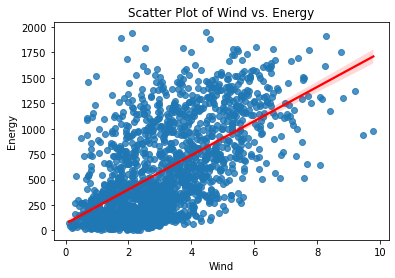

In [117]:

sample_df = joined.select("weighted_wind_speed", "Rolling Average 3h in MWh").sample(False, 0.1, seed=1)
# Convert the DataFrame to Pandas for plotting
pandas_df = sample_df.select("weighted_wind_speed", "Rolling Average 3h in MWh").toPandas()

# Create a scatter plot
sns.regplot(x=pandas_df['weighted_wind_speed'], y=pandas_df['Rolling Average 3h in MWh'], line_kws={"color": "red"})
plt.xlabel('Wind')
plt.ylabel('Energy')
plt.title('Scatter Plot of Wind vs. Energy')
plt.show()